In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pyspark
import numpy as np
import string
import re
from pyspark.sql.functions import isnan, when, count, col
import pyspark.sql.functions as F

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, IntegerType, FloatType, DoubleType, LongType
from pyspark.sql import Row
import pickle
PUNCTUATION = set(string.punctuation)
STOPWORDS = set(stopwords.words('english'))

In [2]:
df = spark.read.csv(
    's3://aws-logs-816063959671-us-east-1/data/Reviews.csv',header=True)

In [3]:
df.cache()

DataFrame[Id: string, ProductId: string, UserId: string, ProfileName: string, HelpfulnessNumerator: string, HelpfulnessDenominator: string, Score: string, Time: string, Summary: string, Text: string]

In [4]:
df.count()

568454

In [5]:
df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: string (nullable = true)
 |-- HelpfulnessDenominator: string (nullable = true)
 |-- Score: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)



## Count nulls

In [6]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+
| Id|ProductId|UserId|ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|Time|Summary|Text|
+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+
|  0|        0|     0|          0|                   0|                     0|    0|   0|      0|   0|
+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+



In [7]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+
| Id|ProductId|UserId|ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|Time|Summary|Text|
+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+
|  0|        0|     0|          0|                   0|                     0|    0|   0|      0|   0|
+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+



# EDA

### Cleaning Text

In [8]:
df.columns

['Id',
 'ProductId',
 'UserId',
 'ProfileName',
 'HelpfulnessNumerator',
 'HelpfulnessDenominator',
 'Score',
 'Time',
 'Summary',
 'Text']

#### Lowercase

In [9]:
for col in ['Summary', 'Text']:
    df = df.withColumn(col, F.lower(F.col(col)))

### Create text length columns

In [10]:
def word_length(string):
    tokens = word_tokenize(string)
    tokens = [w for w in tokens if w not in PUNCTUATION]
    return len(tokens)

In [11]:
function = udf(word_length, LongType())
df = df.withColumn('Summary_len', function(df.Summary))
df = df.withColumn('Text_len', function(df.Text))

### Clean based on Text Length

In [12]:
df.select('Summary_len').describe().show()

+-------+------------------+
|summary|       Summary_len|
+-------+------------------+
|  count|            568454|
|   mean| 4.218930643464555|
| stddev|2.7689527586206704|
|    min|                 0|
|    max|                58|
+-------+------------------+



#### Count instances where the summary length is greater than text length to immediately filter out

In [13]:
df.filter(df.Summary_len >= df.Text_len).count()

1527

In [14]:
df = df.filter(df.Summary_len < df.Text_len)

#### Filter out summaries that are too long

In [15]:
df.filter(df.Summary_len > 20).count()

400

In [16]:
df = df.filter(df.Summary_len <= 20)

### Investigate short summaries

In [17]:
df.filter(df.Summary_len == 0).count()

96

In [18]:
df.select('Summary').filter(df.Summary_len == 0).show(5)

+--------------------+
|             Summary|
+--------------------+
|                  =]|
|                ????|
|$$$$$$$$$$$$$$$$$...|
|                 ???|
|                  $$|
+--------------------+
only showing top 5 rows



In [19]:
df.select('Summary').filter(df.Summary_len == 1).show(20)

+-------------+
|      Summary|
+-------------+
|    twizzlers|
|    twizzlers|
|       yummy!|
|   satisfying|
|   food-great|
|         good|
|        mushy|
|         good|
|   delicious!|
|        great|
|          bad|
|        tart!|
|disappointing|
|       jell-o|
|       tasty!|
|   delicious!|
|        handy|
|      miracle|
|      tasty!!|
|      altoids|
+-------------+
only showing top 20 rows



In [20]:
df.select('Summary').filter(df.Summary_len <= 1).count()

58434

In [21]:
df = df.filter(df.Summary_len > 0)

It looks like summaries with a word length of 1 make up 1/10 of the dataset. Thats a lot of data, this shouldn't be filtered out. Summaries with a word length of 0 seem to be made up of emojis or useless symbols and there are only 96 cases, so those will be removed, as well as summaries with > 20 words

### Investigating source Text length

In [22]:
df.cache()

DataFrame[Id: string, ProductId: string, UserId: string, ProfileName: string, HelpfulnessNumerator: string, HelpfulnessDenominator: string, Score: string, Time: string, Summary: string, Text: string, Summary_len: bigint, Text_len: bigint]

In [23]:
df.select('Text_len').describe().show()

+-------+-----------------+
|summary|         Text_len|
+-------+-----------------+
|  count|           566431|
|   mean|72.41091324450815|
| stddev|63.09016722600273|
|    min|                2|
|    max|             2239|
+-------+-----------------+



In [43]:
df.select('Score').distinct().show()

+--------------+
|         Score|
+--------------+
|       Hugs"""|
|             7|
|            51|
|     friend"""|
|            15|
|            54|
|            11|
|            29|
|            69|
|             3|
|            30|
|      USA ..."|
|             8|
| and Kitten"""|
|            22|
|            28|
|        Design|
|        Dad"""|
|            16|
|            35|
+--------------+
only showing top 20 rows



Score is supposed to be a value 0-5, indicating a product rating. Need to clean this

In [51]:
df.filter(df.Score.isin(['1','2','3','4','5'])).select('Score').distinct().show()

+-----+
|Score|
+-----+
|    3|
|    5|
|    1|
|    4|
|    2|
+-----+



In [53]:
df.filter(df.Score.isin(['1','2','3','4','5'])).select('Score').count()

566813

Great, most of the dataset is still retained

In [54]:
df = df.filter(df.Score.isin(['1','2','3','4','5']))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee05057ac8>]],
      dtype=object)

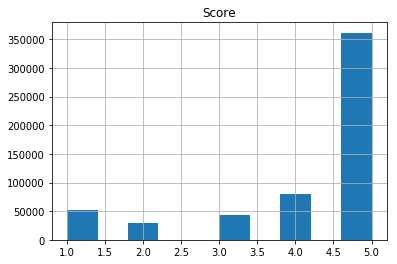

In [55]:
df.select('Score').toPandas().astype('int64').hist()

# The end goal is to create text summarization, and to perform sentiment analysis

In this case, ratings of 1 star (score=1) are considered negative sentiment, while ratings of 5 star are considered positive sentiment. As you can see in the histogram above, users are far more likely to give 5 star reviews. There are also a lack of 1 star reviews. We will create a subset for sentiment analysis and perform random undersampling on the 5 star reviews to create a balanced dataset, which will greatly help the performance of many common models used for sentiment analysis. We will keep the entire dataset to train the text summarization model

In [69]:
subset_1star = df.filter(df.Score == 1)
subset_5star = df.filter(df.Score == 5)
print('# 1 star reviews: {}'.format(subset_1star.count()))
print('# 5 star reviews: {}'.format(subset_5star.count()))


# 1 star reviews: 52635
# 5 star reviews: 361658


### Random undersampling the positive class (5 star reviews)

In [70]:
sample_ratio = subset_1star.count()/subset_5star.count()
subset_5star = subset_5star.sample(withReplacement=False, fraction=sample_ratio)

### Combine the positive and negative classes into one dataframe

In [75]:
subset = subset_1star.union(subset_5star)

# Clean text

In [79]:
df.columns

['Id',
 'ProductId',
 'UserId',
 'ProfileName',
 'HelpfulnessNumerator',
 'HelpfulnessDenominator',
 'Score',
 'Time',
 'Summary',
 'Text']

In [78]:
subset.select('Summary').show()

+--------------------+
|             Summary|
+--------------------+
|   Not as Advertised|
|My Cats Are Not F...|
|     Nasty No flavor|
|       Don't like it|
|      stale product.|
|Warning!  WARNING...|
|       No Tea Flavor|
|                 Bad|
|       Rip off Price|
|Tasteless but low...|
|    Very Low quality|
|    Not Banana Runts|
|These just don't ...|
|CHANGED FORMULA M...|
|Price cannot be c...|
|            Not Good|
|Furniture Polish ...|
|         Sad outcome|
|Don't Waste Your ...|
|Reeks like chemicals|
+--------------------+
only showing top 20 rows

